In [ ]:
from zipfile import ZipFile
import os

# Upload zipped file manually
from google.colab import files
uploaded = files.upload()

# Unzip
with ZipFile("balanced_stock_patterns.zip", 'r') as zip_ref:
    zip_ref.extractall()

# Check if folder exists
print(os.listdir("balanced_stock_patterns"))


KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from sklearn.model_selection import train_test_split
import pandas as pd

# Load your cleaned and balanced annotations
df = pd.read_csv("annotations_balanced.csv")

# Split the data
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Pattern'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Pattern'], random_state=42)

# Add full path to images
base_dir = 'balanced_stock_patterns'
for d in [train_df, val_df, test_df]:
    d['path'] = d.apply(lambda row: os.path.join(base_dir, row['Pattern'].replace(" ", "_"), row['Filename']), axis=1)

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='Pattern',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='Pattern',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='Pattern',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 4900 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1050 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1050 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D, Activation, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay



In [ ]:
l2_reg = l2(0.00025)
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(224, 224, 3),kernel_regularizer=l2_reg),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(2, 2),

    # Block 2
    Conv2D(64, (3, 3), padding='same',activation='relu',kernel_regularizer=l2_reg),
    BatchNormalization(),
    Dropout(0.25),
    MaxPooling2D(2, 2),


    # Block 3
    Conv2D(128, (3, 3), padding='same',activation='relu',kernel_regularizer=l2_reg),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    # Block 4
    Conv2D(256, (3, 3), padding='same',activation='relu',kernel_regularizer=l2_reg),
    BatchNormalization(),
    MaxPooling2D(2, 2),


    # Block 5
    Conv2D(512, (3, 3), padding='same',activation='relu',kernel_regularizer=l2_reg),
    BatchNormalization(),
    Dropout(0.3),
    MaxPooling2D(2, 2),

    # Dense Layers
    GlobalAveragePooling2D(),

    Dense(128, activation='relu',kernel_regularizer=l2_reg),
    Dropout(0.5),

    Dense(14, activation='softmax')  # Output for 14 classes
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.25,min_lr=1e-6, patience=5, verbose=1)]

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # You can increase epochs, callbacks will stop early if needed
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 117s 698ms/step - accuracy: 0.1165 - loss: 3.1094 - val_accuracy: 0.0714 - val_loss: 3.3050 - learning_rate: 1.0000e-04
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 99s 646ms/step - accuracy: 0.2079 - loss: 2.6024 - val_accuracy: 0.0962 - val_loss: 3.2406 - learning_rate: 1.0000e-04
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 100s 652ms/step - accuracy: 0.2739 - loss: 2.4345 - val_accuracy: 0.0714 - val_loss: 3.0896 - learning_rate: 1.0000e-04
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 657ms/step - accuracy: 0.2979 - loss: 2.3530 - val_accuracy: 0.1524 - val_loss: 2.7447 - learning_rate: 1.0000e-04
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 100s 647ms/step - accuracy: 0.3422 - loss: 2.2251 - val_accuracy: 0.2333 - val_loss: 2.3883 - learning_rate: 1.0000e-04
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 101s 654ms/step - accuracy: 0.4126 - loss: 2.0541 - val_accuracy: 0.3352 - val_loss: 2.1983 - learning_rate: 1.0000e-04
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1

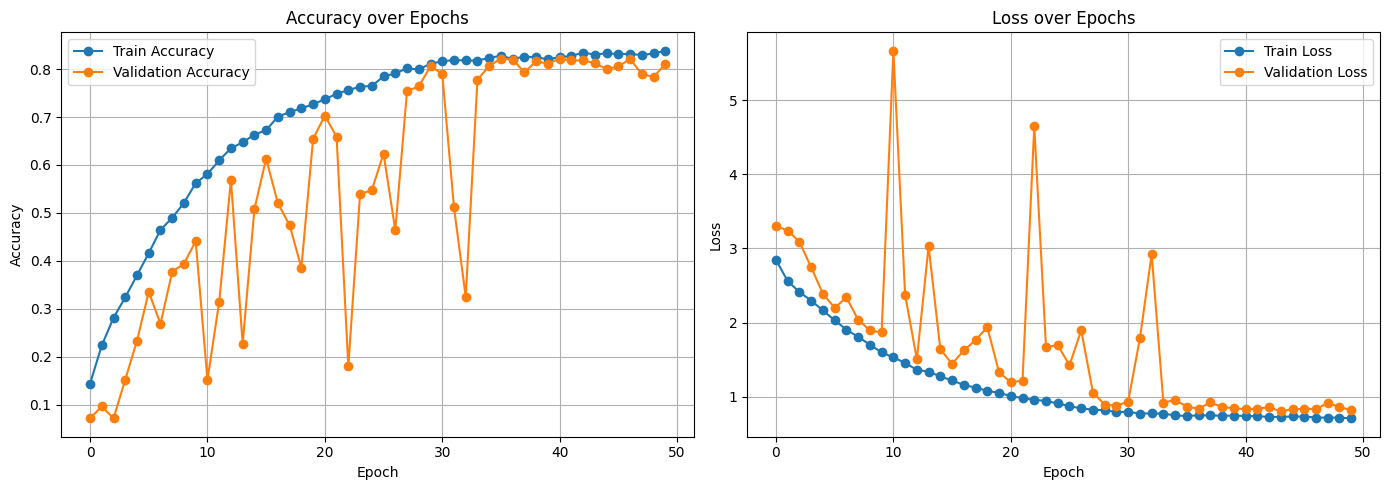

In [ ]:
 import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.8319 - loss: 0.7832
Test Accuracy: 0.8248


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('stock_pattern_cnn_model.h5')


In [ ]:
from sklearn.metrics import classification_report

# Detailed evaluation
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [ ]:
model.save('stock_pattern_cnn_model.h5')

Saving candel(4).jpg to candel(4) (1).jpg
✅ Uploaded: candel(4) (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
🔍 Predicted Pattern: Double Bottom


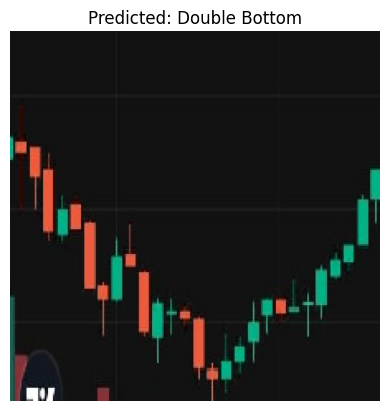

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# --- Step 1: Upload Image Manually ---
from google.colab import files
uploaded = files.upload()  # This opens a file dialog

# Get uploaded filename
import os
image_path = list(uploaded.keys())[0]  # first uploaded file
print("✅ Uploaded:", image_path)

# --- Step 2: Preprocess the image ---
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

img = image.load_img(image_path, target_size=(224, 224), color_mode='rgb')
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# --- Step 3: Predict using your trained model ---
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]

# --- Step 4: Class Labels ---
class_labels = ['Ascending Triangle', 'Bearish Engulfing', 'Bullish Engulfing',
                'Cup and Handle', 'Descending Triangle', 'Double Bottom', 'Double Top',
                'Evening Star', 'Hammer', 'Hanging Man', 'Head and Shoulders',
                'Inverted Hammer', 'Morning Star', 'Shooting Star']

# --- Step 5: Output Prediction and Show Image ---
print(f"🔍 Predicted Pattern: {class_labels[pred_class]}")

plt.imshow(img)
plt.title(f"Predicted: {class_labels[pred_class]}")
plt.axis('off')
plt.show()
